#  Workshop: Employee KPIs Prediction

Data source:
https://www.kaggle.com/datasets/sanjanchaudhari/employees-performance-for-hr-analytics/data

- In this workshop, you will learn to use Grid Search to find the best parameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/!Workshop-698

/content/drive/MyDrive/!Workshop-698


In [43]:
!ls

confusion_matrix_randforest.png  dummy_upload.csv	    Uncleaned_employees_final_dataset.csv
confusion_matrix_xgb.png	 model_kpi_66130701908.pkl  WorkshopEmpKPIsPrediction-std.ipynb
confusion_matrix_xxx.png	 predict-kpi-67xxxx.docx


## Prepare Data

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df_org = pd.read_csv("Uncleaned_employees_final_dataset.csv")

In [ ]:
df = df_org.copy()
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61


In [ ]:
df.shape

(17417, 13)

In [ ]:
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met_more_than_80', 'awards_won',
       'avg_training_score'],
      dtype='object')

In [ ]:
# Iterate through each column and print unique values
for column in df.columns:
    unique_values = df[column].unique()
    print(f"'{column}': {unique_values}")

'employee_id': [ 8724 74430 72255 ... 73858 64573 49584]
'department': ['Technology' 'HR' 'Sales & Marketing' 'Procurement' 'Finance' 'Analytics'
 'Operations' 'Legal' 'R&D']
'region': ['region_26' 'region_4' 'region_13' 'region_2' 'region_29' 'region_7'
 'region_22' 'region_16' 'region_17' 'region_24' 'region_11' 'region_27'
 'region_9' 'region_20' 'region_34' 'region_23' 'region_8' 'region_14'
 'region_31' 'region_19' 'region_5' 'region_28' 'region_15' 'region_3'
 'region_25' 'region_12' 'region_21' 'region_30' 'region_10' 'region_33'
 'region_32' 'region_6' 'region_1' 'region_18']
'education': ['Bachelors' 'Masters & above' nan 'Below Secondary']
'gender': ['m' 'f']
'recruitment_channel': ['sourcing' 'other' 'referred']
'no_of_trainings': [1 3 2 4 5 7 6 8 9]
'age': [24 31 30 36 33 51 29 40 34 37 26 49 27 25 41 52 43 35 42 57 46 21 32 28
 38 23 58 54 44 48 45 39 59 53 56 47 22 20 50 55 60]
'previous_year_rating': [nan  3.  1.  2.  4.  5.]
'length_of_service': [ 1  5  4  9  7  2  3 11

In [ ]:
df = df.drop('employee_id',axis=1)

## Handle Missing Data

In [ ]:
df.isna().sum()/len(df)*100

,0
department,0.000000
region,0.000000
education,4.426710
gender,0.000000
recruitment_channel,0.000000
no_of_trainings,0.000000
age,0.000000
previous_year_rating,7.825688
length_of_service,0.000000
KPIs_met_more_than_80,0.000000


In [ ]:
df['previous_year_rating'].mode()[0]

3.0

In [ ]:
df['education'] = df['education'].fillna('None')
df['previous_year_rating'] = df['previous_year_rating'].fillna(df['previous_year_rating'].mode()[0])

In [ ]:
df.isna().sum()/len(df)*100

,0
department,0.0
region,0.0
education,0.0
gender,0.0
recruitment_channel,0.0
no_of_trainings,0.0
age,0.0
previous_year_rating,0.0
length_of_service,0.0
KPIs_met_more_than_80,0.0


## Categotical Encoding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17417 entries, 0 to 17416
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department             17417 non-null  object 
 1   region                 17417 non-null  object 
 2   education              17417 non-null  object 
 3   gender                 17417 non-null  object 
 4   recruitment_channel    17417 non-null  object 
 5   no_of_trainings        17417 non-null  int64  
 6   age                    17417 non-null  int64  
 7   previous_year_rating   17417 non-null  float64
 8   length_of_service      17417 non-null  int64  
 9   KPIs_met_more_than_80  17417 non-null  int64  
 10  awards_won             17417 non-null  int64  
 11  avg_training_score     17417 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 1.6+ MB


In [ ]:
df

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
0,Technology,region_26,Bachelors,m,sourcing,1,24,3.0,1,1,0,77
1,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51
2,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47
3,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65
4,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...
17412,Technology,region_7,Bachelors,f,referred,2,30,5.0,6,1,0,81
17413,HR,region_7,Bachelors,m,other,1,33,1.0,9,0,0,51
17414,HR,region_7,Bachelors,m,other,1,33,1.0,9,0,0,51
17415,HR,region_7,Bachelors,m,other,1,33,1.0,9,0,0,51


In [ ]:
#Encoding the object columns.
from sklearn.preprocessing import LabelEncoder
department_encoder = LabelEncoder().fit(df['department'])
region_encoder = LabelEncoder().fit(df['region'])
education_encoder = LabelEncoder().fit(df['education'])
gender_encoder = LabelEncoder().fit(df['gender'])
recruitment_channel_encoder = LabelEncoder().fit(df['recruitment_channel'])


In [ ]:
df['department'] = department_encoder.transform(df['department'])
df['region'] = region_encoder.transform(df['region'])
df['education'] = education_encoder.transform(df['education'])
df['gender'] = gender_encoder.transform(df['gender'])
df['recruitment_channel'] = recruitment_channel_encoder.transform(df['recruitment_channel'])


## Correlation of features  

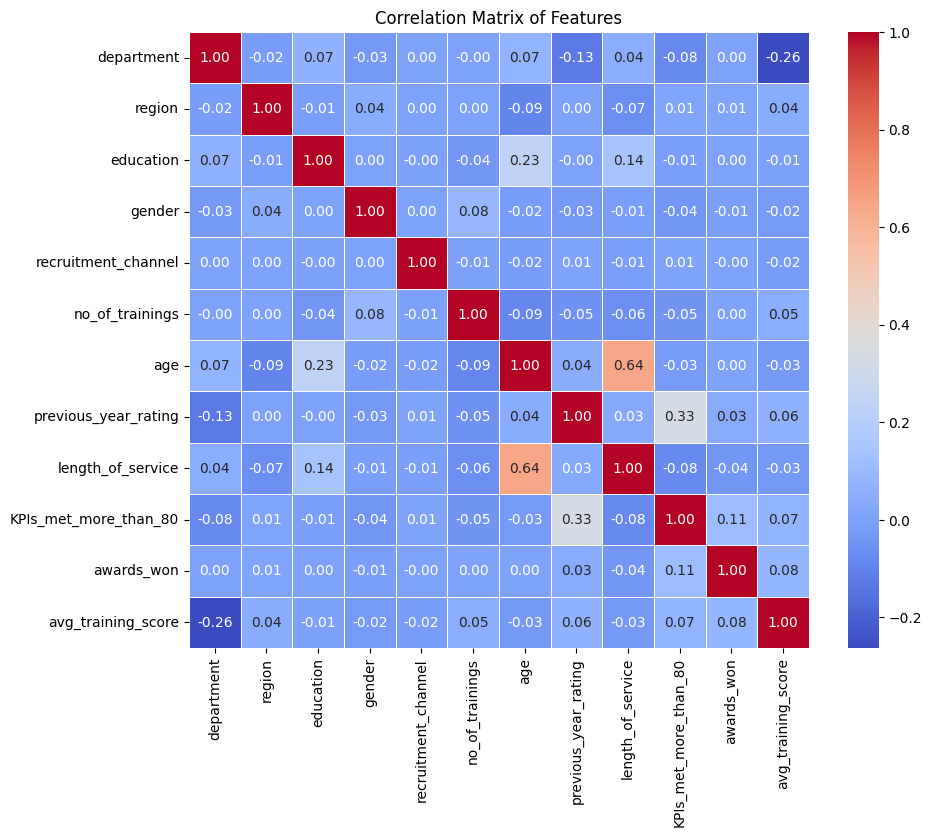

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# If not, replace df with the actual name of your DataFrame

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Show the plot
plt.title('Correlation Matrix of Features')
plt.show()


## Plot in 2 Dimensions using PCA

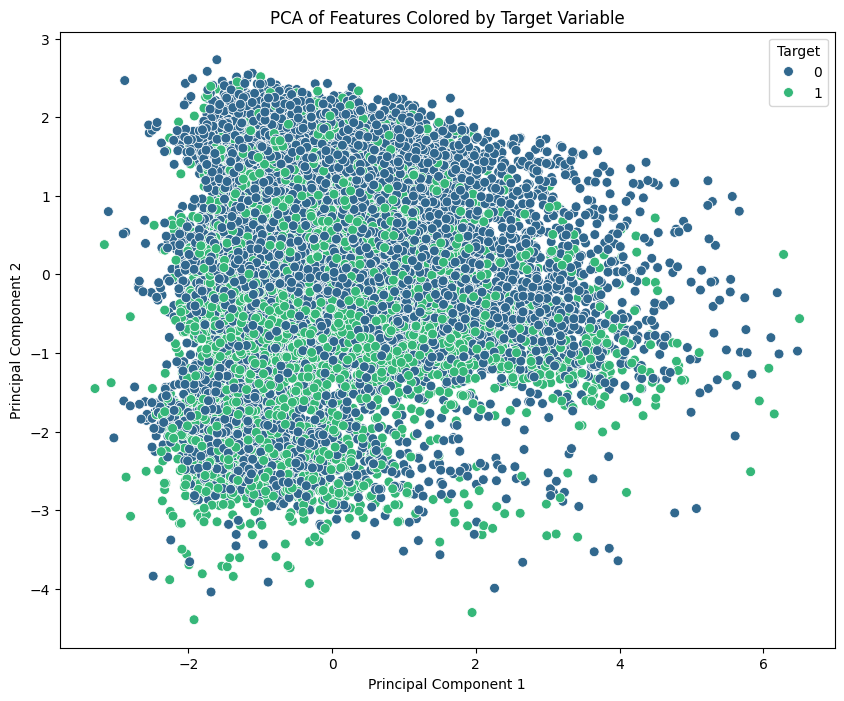

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['department','region','education', 'gender', 'recruitment_channel',
            'no_of_trainings', 'age', 'previous_year_rating',
            'length_of_service', 'awards_won', 'avg_training_score']
X = df[features]
y = df['KPIs_met_more_than_80']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA components and target variable
pca_df = pd.DataFrame(data={'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1], 'target': y})

# Plot the PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='target', data=pca_df, palette='viridis', s=50)
plt.title('PCA of Features Colored by Target Variable')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Target', loc='upper right')
plt.show()

## Select Feature and Target

In [ ]:
df.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met_more_than_80', 'awards_won', 'avg_training_score'],
      dtype='object')

In [ ]:
features = ['department','region','education', 'gender', 'recruitment_channel',
            'no_of_trainings', 'age', 'previous_year_rating',
            'length_of_service', 'awards_won', 'avg_training_score']


In [ ]:
X = df[features]
y = df['KPIs_met_more_than_80']

In [ ]:
X.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score
0,8,18,0,1,2,1,24,3.0,1,0,77
1,2,28,0,0,0,1,31,3.0,5,0,51
2,7,4,0,1,0,1,31,1.0,4,0,47
3,5,11,0,0,0,3,31,2.0,9,0,65
4,1,21,0,1,2,1,30,4.0,7,0,61


## Train/Test Data Split

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into features and target
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Alg1: RandomForest

### Grid Search the best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
model = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Normalization step
    ('rf', RandomForestClassifier(random_state=42))  # You can replace this with any other classifier
])

param_grid = {
    'rf__n_estimators': [10, 100, 1000],
    'rf__max_depth': [None, 10, 20],
}


# Create GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')  # You can adjust cv (cross-validation) as needed

# Fit the pipeline with GridSearchCV
grid_search.fit(X_train, y_train)

# Access the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_


In [ ]:
print(best_params)
print(best_estimator)

{'rf__max_depth': 10, 'rf__n_estimators': 1000}
Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=10, n_estimators=1000,
                                        random_state=42))])


### Training to Create Model with the Best Parameter

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
model = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Normalization step
    ('rf', RandomForestClassifier(random_state=42, max_depth=None, n_estimators=1000))  # You can replace this with any other classifier
])

# Fit the pipeline
model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(n_estimators=1000, random_state=42))])

### Testing / Evaluation

              precision    recall  f1-score   support

           0     0.7298    0.8464    0.7838      2253
           1     0.6028    0.4265    0.4995      1231

    accuracy                         0.6980      3484
   macro avg     0.6663    0.6365    0.6417      3484
weighted avg     0.6849    0.6980    0.6834      3484



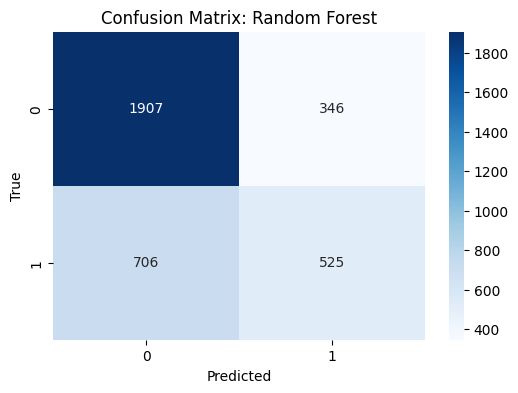

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Make predictions
y_pred = model.predict(X_test)

summary_eval = classification_report(y_test,y_pred,digits=4)
print(summary_eval)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', )
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
# Save the plot as an image file (e.g., PNG)
plt.savefig('confusion_matrix_randforest.png')

plt.show()

## Alg2: XGBoost

### Grid Search the best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Define the pipeline
model = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Normalization step
    ('xgb', XGBClassifier(random_state=42))  # You can replace this with any other classifier
])


param_grid = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}


# Create GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')  # You can adjust cv (cross-validation) as needed

# Fit the pipeline with GridSearchCV
grid_search.fit(X_train, y_train)

# Access the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_


In [ ]:
print(best_params)
print(best_estimator)

{'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 50}
Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
            

### Training to Create Model with the Best Parameter

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Define the pipeline
model = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Normalization step
    ('xgb', XGBClassifier(random_state=42, max_depth=5,  n_estimators=50))  # You can replace this with any other classifier
])

# Fit the pipeline
model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

### Testing / Evaluation

              precision    recall  f1-score   support

           0     0.7335    0.8722    0.7968      2253
           1     0.6422    0.4200    0.5079      1231

    accuracy                         0.7124      3484
   macro avg     0.6879    0.6461    0.6523      3484
weighted avg     0.7012    0.7124    0.6947      3484



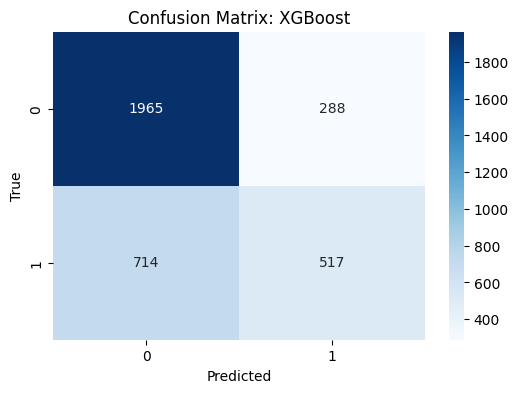

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Make predictions
y_pred = model.predict(X_test)

summary_eval = classification_report(y_test,y_pred,digits=4)
print(summary_eval)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', )
plt.title('Confusion Matrix: XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
# Save the plot as an image file (e.g., PNG)
plt.savefig('confusion_matrix_xgb.png')

plt.show()

## Alg3: KNN

### Grid Search the best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Define the pipeline
model = Pipeline(steps=[
    ('scaler', StandardScaler()),   # Normalization step
    ('knn', KNeighborsClassifier()) # You can replace this with any other classifier
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9] # Number of neighbors
}

# Create GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy') # You can adjust cv (cross-validation) as needed

# Fit the pipeline with GridSearchCV
grid_search.fit(X_train, y_train)

# Access the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_


In [ ]:
print(best_params)
print(best_estimator)

{'knn__n_neighbors': 9}
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9))])


### Training to Create Model with the Best Parameter

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Define the pipeline
model = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Normalization step
    ('knn', KNeighborsClassifier(n_neighbors=9))  # You can replace this with any other classifier
])

# Fit the pipeline
model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9))])

### Testing / Evaluation

              precision    recall  f1-score   support

           0     0.7258    0.8296    0.7742      2253
           1     0.5776    0.4265    0.4907      1231

    accuracy                         0.6871      3484
   macro avg     0.6517    0.6280    0.6324      3484
weighted avg     0.6734    0.6871    0.6740      3484



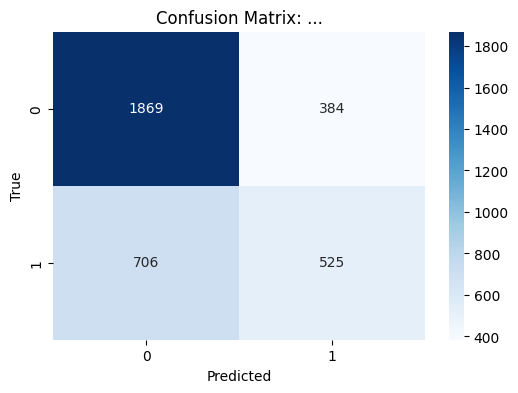

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Make predictions
y_pred = model.predict(X_test)

summary_eval = classification_report(y_test,y_pred,digits=4)
print(summary_eval)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', )
plt.title('Confusion Matrix: ...')
plt.xlabel('Predicted')
plt.ylabel('True')
# Save the plot as an image file (e.g., PNG)
plt.savefig('confusion_matrix_xxx.png')

plt.show()

## Select the Best Model to Create on All Data, i.e., (X,y), and Save Model


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Define the pipeline
model = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Normalization step
    ('xgb', XGBClassifier(random_state=42, max_depth=5,  n_estimators=50))  # You can replace this with any other classifier
])

# Fit the pipeline
model.fit(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
import pickle
# Create a tuple or any container object with your variables
data_to_save = (model, department_encoder, region_encoder, education_encoder, gender_encoder, recruitment_channel_encoder)

# Open a file in binary write mode
with open('model_kpi_66130701908.pkl', 'wb') as file:
    # Save the container object
    pickle.dump(data_to_save, file)

## Load Model and Prediction

Kernel -> Restart Kernel..

### Load model

In [44]:
import pickle
import pandas as pd

with open('model_kpi_66130701908.pkl', 'rb') as file:
    # Load the data from the file
    model, department_encoder, region_encoder, education_encoder, gender_encoder, recruitment_channel_encoder = pickle.load(file)



### New data

In [45]:
# Get user input for each variable
x_new =  pd.DataFrame()
x_new['department'] = ['Technology']
x_new['region'] = ['region_26']
x_new['education'] = ['Bachelors']
x_new['gender'] = ['m']
x_new['recruitment_channel'] = ['sourcing']
x_new['no_of_trainings'] = [1]
x_new['age'] = [24]
x_new['previous_year_rating'] = [2]
x_new['length_of_service'] = [1]
x_new['awards_won'] = [0]
x_new['avg_training_score'] = [77]

In [46]:
x_new

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score
0,Technology,region_26,Bachelors,m,sourcing,1,24,2,1,0,77


### Categorical Data Encoding

In [48]:
x_new

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score
0,8,18,0,1,2,1,24,2,1,0,77


In [47]:
x_new['department'] = department_encoder.transform(x_new['department'])
x_new['region'] = region_encoder.transform(x_new['region'])
x_new['education'] = education_encoder.transform(x_new['education'])
x_new['gender'] = gender_encoder.transform(x_new['gender'])
x_new['recruitment_channel'] = recruitment_channel_encoder.transform(x_new['recruitment_channel'])

### Predicting

In [49]:
y_pred_new = model.predict(x_new)

result = y_pred_new

print('KPIs_met_more_than_80: ', result)

KPIs_met_more_than_80:  [0]


## Create file app_KPI.py

In [50]:
%%writefile app_KPI_66130701908.py

import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load model and encoders
with open('model_kpi_66130701908.pkl', 'rb') as file:
    model, department_encoder, region_encoder, education_encoder, gender_encoder, recruitment_channel_encoder = pickle.load(file)

# Load your DataFrame
# Replace 'your_data.csv' with the actual file name or URL
df = pd.read_csv('Uncleaned_employees_final_dataset.csv')
df = df.drop('employee_id', axis=1)

# Streamlit App
st.title('Employee KPIs App')

# Define a session state to remember tab selections
if 'tab_selected' not in st.session_state:
    st.session_state.tab_selected = 0

# Create tabs for prediction and visualization
tabs = ['Predict KPIs', 'Visualize Data', 'Predict from CSV']
selected_tab = st.radio('Select Tab:', tabs, index=st.session_state.tab_selected)

# Tab selection logic
if selected_tab != st.session_state.tab_selected:
    st.session_state.tab_selected = tabs.index(selected_tab)

# Tab 1: Predict KPIs
if st.session_state.tab_selected == 0:
    st.header('Predict KPIs')

    # User Input Form
    department = st.selectbox('Department', department_encoder.classes_)
    region = st.selectbox('Region', region_encoder.classes_)
    education = st.selectbox('Education', education_encoder.classes_)
    gender = st.radio('Gender', gender_encoder.classes_)
    recruitment_channel = st.selectbox('Recruitment Channel', recruitment_channel_encoder.classes_)
    no_of_trainings = st.slider('Number of Trainings', 1, 10, 1)
    age = st.slider('Age', 18, 60, 30)
    previous_year_rating = st.slider('Previous Year Rating', 1.0, 5.0, 3.0)
    length_of_service = st.slider('Length of Service', 1, 20, 5)
    awards_won = st.checkbox('Awards Won')
    avg_training_score = st.slider('Average Training Score', 40, 100, 70)

    # Create a DataFrame for the user input
    user_input = pd.DataFrame({
        'department': [department],
        'region': [region],
        'education': [education],
        'gender': [gender],
        'recruitment_channel': [recruitment_channel],
        'no_of_trainings': [no_of_trainings],
        'age': [age],
        'previous_year_rating': [previous_year_rating],
        'length_of_service': [length_of_service],
        'awards_won': [1 if awards_won else 0],
        'avg_training_score': [avg_training_score]
    })

    # Categorical Data Encoding
    user_input['department'] = department_encoder.transform(user_input['department'])
    user_input['region'] = region_encoder.transform(user_input['region'])
    user_input['education'] = education_encoder.transform(user_input['education'])
    user_input['gender'] = gender_encoder.transform(user_input['gender'])
    user_input['recruitment_channel'] = recruitment_channel_encoder.transform(user_input['recruitment_channel'])

    # Predicting
    prediction = model.predict(user_input)

    # Display Result
    st.subheader('Prediction Result:')
    st.write('KPIs_met_more_than_80:', prediction[0])

# Tab 2: Visualize Data
elif st.session_state.tab_selected == 1:
    st.header('Visualize Data')

    # Select condition feature
    condition_feature = st.selectbox('Select Condition Feature:', df.columns)

    # Set default condition values
    default_condition_values = ['Select All'] + df[condition_feature].unique().tolist()

    # Select condition values
    condition_values = st.multiselect('Select Condition Values:', default_condition_values)

    # Handle 'Select All' choice
    if 'Select All' in condition_values:
        condition_values = df[condition_feature].unique().tolist()

    if len(condition_values) > 0:
        # Filter DataFrame based on selected condition
        filtered_df = df[df[condition_feature].isin(condition_values)]

        # Plot the number of employees based on KPIs
        fig, ax = plt.subplots(figsize=(14, 8))
        sns.countplot(x=condition_feature, hue='KPIs_met_more_than_80', data=filtered_df, palette='viridis')
        plt.title('Number of Employees based on KPIs')
        plt.xlabel(condition_feature)
        plt.ylabel('Number of Employees')
        st.pyplot(fig)

# Tab 3: Predict from CSV
elif st.session_state.tab_selected == 2:
    st.header('Predict from CSV')

    # Upload CSV file
    uploaded_file = st.file_uploader("Upload CSV file", type=["csv"])
    # uploaded_file

    if uploaded_file is not None:
        # Read CSV file
        csv_df_org = pd.read_csv(uploaded_file)
        csv_df_org = csv_df_org.dropna()
        # csv_df_org.columns

        csv_df = csv_df_org.copy()
        csv_df = csv_df.drop('employee_id',axis=1)



         # Categorical Data Encoding
        csv_df['department'] = department_encoder.transform(csv_df['department'])
        csv_df['region'] = region_encoder.transform(csv_df['region'])
        csv_df['education'] = education_encoder.transform(csv_df['education'])
        csv_df['gender'] = gender_encoder.transform(csv_df['gender'])
        csv_df['recruitment_channel'] = recruitment_channel_encoder.transform(csv_df['recruitment_channel'])


        # Predicting
        predictions = model.predict(csv_df)

        # Add predictions to the DataFrame
        csv_df_org['KPIs_met_more_than_80'] = predictions

        # Display the DataFrame with predictions
        st.subheader('Predicted Results:')
        st.write(csv_df_org)

        # Visualize predictions based on a selected feature
        st.subheader('Visualize Predictions')

        # Select feature for visualization
        feature_for_visualization = st.selectbox('Select Feature for Visualization:', csv_df_org.columns)

        # Plot the number of employees based on KPIs for the selected feature
        fig, ax = plt.subplots(figsize=(14, 8))
        sns.countplot(x=feature_for_visualization, hue='KPIs_met_more_than_80', data=csv_df_org, palette='viridis')
        plt.title(f'Number of Employees based on KPIs - {feature_for_visualization}')
        plt.xlabel(feature_for_visualization)
        plt.ylabel('Number of Employees')
        st.pyplot(fig)



Writing app_KPI_66130701908.py


## Deploy on Streamlit Sharing

https://share.streamlit.io/

https://github.com/



In [51]:
%%writefile requirements.txt

scikit-learn==1.2.2
pandas


Writing requirements.txt
